# 第五周作业

## Use only ChatBot with LangGraph

----

### create graph_builder and State

In [2]:

from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

### Create Chat LLM

In [3]:
from langchain_openai import ChatOpenAI

# 初始化一个 GPT-4o-mini 模型
chat_model = ChatOpenAI(model="gpt-4o-mini")

def chatbot(state: State):
    return {"messages": [chat_model.invoke(state["messages"])] }

graph_builder.add_node("chatbot", chatbot)


### Define chat flow, with Edge


In [4]:
graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", END)


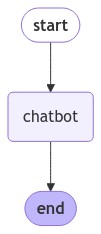

In [5]:
graph = graph_builder.compile()

# 你可以使用 get_graph 方法来可视化图，并结合 draw 方法（如 draw_ascii 或 draw_png）
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

### Loop user input , call graph and print

In [8]:

while True:
    user_input = input("Type your query:")

    if user_input.lower() in ["exit","quit", "q"]:
        print("Good bye")
        break

    for event in graph.stream({"messages": ("user", user_input) }):

        for value in event.values():
            print("AI Message:", value["messages"][-1].content)
            

Type your query: 中国队在2024巴黎奥运会获得多少奖牌？


AI Message: 截至我的知识截止日期（2023年10月），2024年巴黎奥运会还未举行，因此无法提供中国队获得奖牌的具体数量。巴黎奥运会将于2024年7月26日至8月11日举行，届时会有关于各国代表队和运动员表现的最新资讯。请关注相关体育新闻以获取最新的赛事结果和奖牌统计。


Type your query: exit


Good bye


### chatbot only 运行结果

Type your query: 中国队在2024巴黎奥运会获得多少奖牌？
AI Message: 截至我的知识截止日期（2023年10月），2024年巴黎奥运会还未举行，因此无法提供中国队获得奖牌的具体数量。巴黎奥运会将于2024年7月26日至8月11日举行，届时会有关于各国代表队和运动员表现的最新资讯。请关注相关体育新闻以获取最新的赛事结果和奖牌统计。
Type your query: exit
Good bye


## Add tools to Chatbot

### Define tool and bind tool to LLM


In [9]:
from langchain_community.tools.tavily_search import TavilySearchResults

# 定义 Tavily 搜索工具，最大搜索结果数设置为 2
tool = TavilySearchResults(max_results=2)
tools = [tool]

# 测试工具调用
tool.invoke("How many gold medals did China win at the 2024 Paris Olympics?")

[{'url': 'https://www.npr.org/2024/08/02/nx-s1-5061584/china-paris-olympic-gold-medal-count',
  'content': "Chinese shooters have accounted for four of China's 13 gold medals. NPR is in Paris for the 2024 Summer Olympics. For more of our coverage from the Games, head to our latest updates. PARIS — As ..."},
 {'url': 'https://olympics.com/en/paris-2024/medals',
  'content': "Official medal standings for the Paris 2024 Olympics (Jul 26-Aug 11, 2024). Find out which athletes are bringing home medals and breaking records. ... CHN People's Republic of China. 40 27 24 91. JPN Japan. 20 12 13 45. AUS Australia. 18 19 16 53. FRA France. 16 26 22 64. NED Netherlands. 15 7 12 34. ... Does not include medals won by AIN ..."}]

### Start build new graph for LLM with Tools

---

In [37]:
## Bind to LLM

from typing import Annotated
from langchain_openai import ChatOpenAI
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START
from langgraph.graph.message import add_messages


# 定义状态
class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

# 初始化 LLM 并绑定搜索工具
chat_model = ChatOpenAI(model="gpt-4o-mini")
llm_with_tools = chat_model.bind_tools(tools)

# 更新聊天机器人节点函数，支持工具调用
def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

# 将更新后的节点添加到状态图中
graph_builder.add_node("chatbot", chatbot)

In [38]:
## Handle Tools invokation 

import json
from langchain_core.messages import ToolMessage

class TavilySearchNode:
    """ A node run after LLM AIMessage
    Tool node will check AIMessage if including tool invocation, 
    then invoke tools one by one.
    """

    def __init__(self, tools: list) -> None:
        ## Save tools in a dictionary named 'tools_by_name' and use 
        ## tool's name as "KEY"
        self.tools_by_name = {tool.name: tool for tool in tools}

    def __call__(self, input:dict):
        if messages := input.get("messages", []):
            last_message = messages[-1]
        else :
            raise ValueError("输入中未找到消息")

        ## tools output list 
        outputs = []

        for tool_call in last_message.tool_calls:
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )
            outputs.append(
                ToolMessage(
                    content = json.dumps(tool_result),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"]
                )
            )
        # retur tool call results
        return {"messages": outputs}
        

### Bind tool to llm 

In [39]:

tool_node = TavilySearchNode(tools=[tool])
graph_builder.add_node("tools", tool_node)


### Define router edge for tools

In [40]:
from typing import Literal

def route_tools(
    state: State,
) -> Literal["tools", "__end__"]:

    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"输入状态中未找到消息: {state}")

    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"   
    return "__end__" 

## graph_builder add conditional edage
graph_builder.add_conditional_edges(
    "chatbot",  
    route_tools,  
    {"tools": "tools", "__end__": "__end__"},  
)

## Add edge once tools finished, then go to chatbot 
graph_builder.add_edge("tools", "chatbot")

## point START to chatbot
graph_builder.add_edge(START, "chatbot")


### Build and display LangGraph

In [41]:
graph = graph_builder.compile()

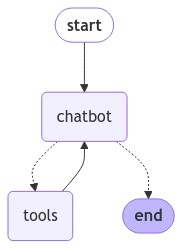

In [42]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

### Run and get result 

---

In [43]:
from langchain_core.messages import BaseMessage

# 进入一个无限循环，用于模拟持续的对话
while True:
    # 获取用户输入
    user_input = input("User: ")
    
    # 如果用户输入 "quit"、"exit" 或 "q"，则退出循环，结束对话
    if user_input.lower() in ["quit", "exit", "q"]:
        print("Goodbye!")  # 打印告别语
        break  # 退出循环

    # 使用 graph.stream 处理用户输入，并生成机器人的回复
    # "messages" 列表中包含用户的输入，传递给对话系统
    for event in graph.stream({"messages": [("user", user_input)]}):
        
        # 遍历 event 的所有值，检查是否是 BaseMessage 类型的消息
        for value in event.values():
            if isinstance(value["messages"][-1], BaseMessage):
                # 如果消息是 BaseMessage 类型，则打印机器人的回复
                print("Assistant:", value["messages"][-1].content)


User:  中国队在2024巴黎奥运会获得多少块奖牌？


Assistant: 
Assistant: [{"url": "https://www.usatoday.com/story/sports/olympics/2024/07/24/olympic-medal-count-by-country/74441212007/", "content": "2024 Paris Olympics: Follow USA TODAY's coverage of the biggest names and stories of the Games. 1. USA \u2014 126 (40 gold, 44 silver, 42 bronze) 2. China \u2014 91 (40 gold, 27 silver, 24 bronze) 3 ..."}, {"url": "https://apnews.com/article/2024-olympics-medals-united-states-china-e9f013a206e0de69c41686ee122f425a", "content": "Updated 11:10 PM PDT, August 11, 2024. PARIS (AP) \u2014 The contest for most gold medals at the Paris Olympics ended in a 40-40 tie between China and the United States. But the U.S. topped the medals table with a whopping 126 overall, compared to 91 for China. At the Tokyo Games, the U.S. also edged China in the medal count, finishing with 113 ..."}]
Assistant: 在2024年巴黎奥运会上，中国队共获得91块奖牌，其中包括40枚金牌、27枚银牌和24枚铜牌。


User:  bye


Assistant: Goodbye! If you have any more questions in the future, feel free to ask. Have a great day!


User:  exit


Goodbye!


## Result compare 

### Only Chatbot

 - no data in LLM, can't answer query

```
  Type your query: 中国队在2024巴黎奥运会获得多少奖牌？
  AI Message: 截至我的知识截止日期（2023年10月），2024年巴黎奥运会还未举行，因此无法提供中国队获得奖牌的具体数量。巴黎奥运会将于2024年7月26 日至8月11日举行，届时会有关于各国代表队和运动员表现的最新资讯。请关注相关体育新闻以获取最新的赛事结果和奖牌统计。
  Type your query: exit
  Good bye
```

### Chatbot with Tools 

 - Can answer query, via searching question from internet.

```
 User:  中国队在2024巴黎奥运会获得多少块奖牌？
 Assistant: 
 Assistant: [{"url": "https://www.usatoday.com/story/sports/olympics/2024/07/24/olympic-medal-count-by-country/74441212007/", "content": "2024 Paris Olympics: Follow USA TODAY's coverage of the biggest names and stories of the Games. 1. USA \u2014 126 (40 gold, 44 silver, 42 bronze) 2. China \u2014 91 (40 gold, 27 silver, 24 bronze) 3 ..."}, {"url": "https://apnews.com/article/2024-olympics-medals-united-states-china-e9f013a206e0de69c41686ee122f425a", "content": "Updated 11:10 PM PDT, August 11, 2024. PARIS (AP) \u2014 The contest for most gold medals at the Paris Olympics ended in a 40-40 tie between China and the United States. But the U.S. topped the medals table with a whopping 126 overall, compared to 91 for China. At the Tokyo Games, the U.S. also edged China in the medal count, finishing with 113 ..."}]
 Assistant: 在2024年巴黎奥运会上，中国队共获得91块奖牌，其中包括40枚金牌、27枚银牌和24枚铜牌。
 User:  bye
 Assistant: Goodbye! If you have any more questions in the future, feel free to ask. Have a great day!
 User:  exit
 Goodbye!
```